# 準備

## Import 

In [1]:
# !pip install albumentations

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import torchvision
import numpy as np
import gc  
from albumentations import (
    Compose, Normalize, Resize,
    RandomResizedCrop, HorizontalFlip,
    RandomBrightnessContrast, ShiftScaleRotate
)
from albumentations.pytorch import ToTensorV2
import cv2
from datetime import datetime
import pytz
from tqdm import tqdm

In [3]:
class Config:
    patience=10
    num_epochs=80
    mixup_epochs=5
    batch_size=24
    
config = Config()

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Use a chosen seed
set_seed(42)

In [5]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# Get current date and time in JST
jst = pytz.timezone('Asia/Tokyo')
current_datetime = datetime.now(jst)
# Get current date and time
formatted_datetime = current_datetime.strftime('%Y%m%d%H%M%S')

print(formatted_datetime)

20230826225113


In [7]:
# formatted_datetime = 20230821150755

## Path

## def

In [8]:
def view_img(dir_name, file_name):
    
    info_table = pd.read_csv(f'../data/{dir_name}.csv', header=None, names=['name', 'label'])
    target_label = info_table[info_table['name']==f'{file_name}']['label']
    
    # # Display the image
    img = Image.open(f'../data/{dir_name}/'+file_name)
    # img = Image.open('../data/train_1/'+f'train_1811.png')
    
    plt.title(file_name)
    plt.imshow(img)
    plt.show()

    print("Label:", target_label.values[0])  # values[0] is used to get the first value if multiple rows match the condition
    print("Size of the image:", img.size)


# EDA

In [9]:
# df = pd.read_csv('../data/train_1.csv', header=None, names=['name', 'label'])
# df.head(3)

In [10]:
# random_idx = random.choice(range(len(df)))
# file_name = f'train_{random_idx}.png'
# dir_name = 'train_1'

# view_img(dir_name, file_name)

In [11]:
# # Directory to search
# directory = "../data/train_1/"

# # Maximum file size in bytes (40K in this case)
# max_size = 40 * 1024

# # Get list of files in the directory and subdirectories
# file_list = []

# for directory in ["../data/train_1/","../data/train_2/","../data/train_3/","../data/train_4/"]:
#     for foldername, subfolders, filenames in os.walk(directory):
#         for filename in filenames:
#             full_path = os.path.join(foldername, filename)
#             if os.path.getsize(full_path) <= max_size:
#                 file_list.append(full_path)

In [12]:
# file_list

In [13]:
# file_name = f'train_1474.png'
# dir_name = 'train_3'

# view_img(dir_name, file_name)

In [14]:
# # Get image paths for label 0 and 1
# image_paths_0 = df[df['label'] == 0]['name'].values
# image_paths_1 = df[df['label'] == 1]['name'].values

# # Function to display images
# def display_images(image_paths, title):
#     plt.figure(figsize=(10,10))
#     for i in range(9):  # display 9 images
#         plt.subplot(3,3,i+1)
#         img = Image.open(image_paths[i])
#         plt.imshow(img)
#         plt.title(title)
#         plt.axis('off')
#     plt.show()

# # Display images for label 0 and 1
# display_images('../data/train_1/'+ image_paths_0, 'label_0')
# display_images('../data/train_1/'+ image_paths_1, 'label_1')

# ## 画像が欠損しているデータもあり

In [15]:
# df.groupby('label')['name'].count()

# ベースモデル

## 学習フェーズ

### 関数

In [16]:
def get_transforms():
    transforms_dict = {
        'train': Compose([
            RandomResizedCrop(512, 512),
            HorizontalFlip(),
            RandomBrightnessContrast(),
            ShiftScaleRotate(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        'valid': Compose([
            Resize(512, 512),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
    }
    return transforms_dict


def load_datasets(df, root_dir, transforms_dict):
    train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
    datasets = {
        'train': CustomImageDataset(train_df, root_dir, transform=transforms_dict['train']),
        'valid': CustomImageDataset(valid_df, root_dir, transform=transforms_dict['valid'])
    }
    return datasets


def get_dataloaders(datasets, batch_size):
    dataloaders = {
        'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(datasets['valid'], batch_size=batch_size, shuffle=False)
    }
    return dataloaders

    
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        label = self.df.iloc[idx, 1]
        if self.transform:
            transformed = self.transform(image=image)  # Apply the transformations
            image = transformed["image"]
        return image, label
    
def train_model(dataloaders, model, criterion, optimizer, num_epochs, file_name):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct_predictions += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            


    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
    
    
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
          

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
    # val_loss_minの値を取得
    def get_value(self):
        return self.val_loss_min
        
def train_model_mixup_el_stop(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, path=f'../models/{formatted_datetime}_{file_name}.pth',verbose=True)
    stop_training = False  # 早期停止フラグ
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid':
                early_stopping(-epoch_acc, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    stop_training = True
                    break

        if stop_training:
            break
 
    print('Finished Training') 
    
    return early_stopping.get_value()

### 実行

In [17]:
eval_dict=dict()

for ds in ['train_1','train_2','train_3','train_4']:
# for ds in ['train_3','train_4']:

    print(f'=== {ds}  学習中 ===')
    
    # Load labels from csv
    df = pd.read_csv(f'../data/{ds}.csv', header=None, names=['name', 'label'])
    
    # 40kB以下の空白画像をdfから削除
    file_list = []
    for foldername, subfolders, filenames in os.walk(os.path.join("../data/",ds)):
        for filename in filenames:
            full_path = os.path.join(foldername, filename)
            max_size = 40 * 1024
            if os.path.getsize(full_path) <= max_size:
                file_list.append(filename)
    df = df[~df['name'].isin(file_list)]
    
    # Get transforms
    transforms_dict = get_transforms()

    # Load datasets
    datasets = load_datasets(df, f'../data/{ds}/', transforms_dict)

    # Create dataloaders
    dataloaders = get_dataloaders(datasets, batch_size=config.batch_size)

    # Define model
    model = torchvision.models.resnet50()
    model.fc = nn.Linear(model.fc.in_features, 2) 
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train the model
#     train_model(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds)
#     train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds, mixup_epochs=10)
    eval_dict[ds]= train_model_mixup_el_stop(
        dataloaders,
        model, 
        criterion,
        optimizer,
        num_epochs=config.num_epochs,
        file_name=ds, 
        mixup_epochs=config.mixup_epochs,
        patience=config.patience
    )

del df
del dataloaders
gc.collect()

=== train_1  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 165/165 [04:18<00:00,  1.57s/it]


train Loss: 0.8523 Acc: 0.5403


100%|███████████████████████████████████████████| 42/42 [00:27<00:00,  1.55it/s]


valid Loss: 0.6061 Acc: 0.6307
Validation loss decreased (inf --> -0.630676).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 165/165 [04:08<00:00,  1.51s/it]


train Loss: 0.7243 Acc: 0.5824


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.6598 Acc: 0.6509
Validation loss decreased (-0.630676 --> -0.650858).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 165/165 [04:15<00:00,  1.55s/it]


train Loss: 0.7153 Acc: 0.5968


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.7491 Acc: 0.6519
Validation loss decreased (-0.650858 --> -0.651867).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 165/165 [04:08<00:00,  1.51s/it]


train Loss: 0.7606 Acc: 0.5940


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.59it/s]


valid Loss: 0.5756 Acc: 0.6963
Validation loss decreased (-0.651867 --> -0.696266).  Saving model ...
Epoch 5/80
----------


100%|█████████████████████████████████████████| 165/165 [04:13<00:00,  1.53s/it]


train Loss: 0.7290 Acc: 0.6023


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 1.0834 Acc: 0.6125
EarlyStopping counter: 1 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.6653 Acc: 0.6558


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.5623 Acc: 0.7084
Validation loss decreased (-0.696266 --> -0.708375).  Saving model ...
Epoch 7/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.6716 Acc: 0.6384


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.5473 Acc: 0.7417
Validation loss decreased (-0.708375 --> -0.741675).  Saving model ...
Epoch 8/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.6629 Acc: 0.6470


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.5754 Acc: 0.6781
EarlyStopping counter: 1 out of 10
Epoch 9/80
----------


100%|█████████████████████████████████████████| 165/165 [04:06<00:00,  1.49s/it]


train Loss: 0.6455 Acc: 0.6492


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.60it/s]


valid Loss: 0.5135 Acc: 0.7397
EarlyStopping counter: 2 out of 10
Epoch 10/80
----------


100%|█████████████████████████████████████████| 165/165 [04:09<00:00,  1.51s/it]


train Loss: 0.6639 Acc: 0.6460


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.60it/s]


valid Loss: 0.4865 Acc: 0.7891
Validation loss decreased (-0.741675 --> -0.789102).  Saving model ...
Epoch 11/80
----------


100%|█████████████████████████████████████████| 165/165 [04:06<00:00,  1.50s/it]


train Loss: 0.6461 Acc: 0.6689


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.7920 Acc: 0.7124
EarlyStopping counter: 1 out of 10
Epoch 12/80
----------


100%|█████████████████████████████████████████| 165/165 [04:13<00:00,  1.54s/it]


train Loss: 0.6262 Acc: 0.6831


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.60it/s]


valid Loss: 0.5210 Acc: 0.7447
EarlyStopping counter: 2 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 165/165 [04:08<00:00,  1.51s/it]


train Loss: 0.5990 Acc: 0.6795


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.5786 Acc: 0.7659
EarlyStopping counter: 3 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.5764 Acc: 0.7048


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.56it/s]


valid Loss: 0.4776 Acc: 0.7730
EarlyStopping counter: 4 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 165/165 [04:15<00:00,  1.55s/it]


train Loss: 0.6232 Acc: 0.6846


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.4865 Acc: 0.7719
EarlyStopping counter: 5 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.5703 Acc: 0.7035


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.4926 Acc: 0.7709
EarlyStopping counter: 6 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.5480 Acc: 0.7283


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.4635 Acc: 0.7830
EarlyStopping counter: 7 out of 10
Epoch 18/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.5627 Acc: 0.7235


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.5974 Acc: 0.7185
EarlyStopping counter: 8 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.5550 Acc: 0.7247


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.4609 Acc: 0.7891
Validation loss decreased (-0.789102 --> -0.789102).  Saving model ...
Epoch 20/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.5444 Acc: 0.7288


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.4638 Acc: 0.8083
Validation loss decreased (-0.789102 --> -0.808274).  Saving model ...
Epoch 21/80
----------


100%|█████████████████████████████████████████| 165/165 [04:13<00:00,  1.54s/it]


train Loss: 0.5232 Acc: 0.7437


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.4705 Acc: 0.7699
EarlyStopping counter: 1 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 165/165 [04:14<00:00,  1.54s/it]


train Loss: 0.5165 Acc: 0.7472


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.56it/s]


valid Loss: 0.4952 Acc: 0.7719
EarlyStopping counter: 2 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 165/165 [04:11<00:00,  1.53s/it]


train Loss: 0.5081 Acc: 0.7513


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3979 Acc: 0.8184
Validation loss decreased (-0.808274 --> -0.818365).  Saving model ...
Epoch 24/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.5164 Acc: 0.7465


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3916 Acc: 0.8476
Validation loss decreased (-0.818365 --> -0.847629).  Saving model ...
Epoch 25/80
----------


100%|█████████████████████████████████████████| 165/165 [04:03<00:00,  1.47s/it]


train Loss: 0.5185 Acc: 0.7470


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3937 Acc: 0.8426
EarlyStopping counter: 1 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 165/165 [04:08<00:00,  1.51s/it]


train Loss: 0.5033 Acc: 0.7596


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5414 Acc: 0.7901
EarlyStopping counter: 2 out of 10
Epoch 27/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.5090 Acc: 0.7538


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4348 Acc: 0.7830
EarlyStopping counter: 3 out of 10
Epoch 28/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.5060 Acc: 0.7556


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.4175 Acc: 0.8335
EarlyStopping counter: 4 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 165/165 [04:01<00:00,  1.46s/it]


train Loss: 0.4919 Acc: 0.7558


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.4434 Acc: 0.8184
EarlyStopping counter: 5 out of 10
Epoch 30/80
----------


100%|█████████████████████████████████████████| 165/165 [04:06<00:00,  1.49s/it]


train Loss: 0.4872 Acc: 0.7687


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5483 Acc: 0.7830
EarlyStopping counter: 6 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 165/165 [04:05<00:00,  1.49s/it]


train Loss: 0.5017 Acc: 0.7654


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3830 Acc: 0.8163
EarlyStopping counter: 7 out of 10
Epoch 32/80
----------


100%|█████████████████████████████████████████| 165/165 [04:06<00:00,  1.50s/it]


train Loss: 0.4879 Acc: 0.7657


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3865 Acc: 0.8446
EarlyStopping counter: 8 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 165/165 [04:05<00:00,  1.49s/it]


train Loss: 0.4799 Acc: 0.7664


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3468 Acc: 0.8436
EarlyStopping counter: 9 out of 10
Epoch 34/80
----------


100%|█████████████████████████████████████████| 165/165 [04:07<00:00,  1.50s/it]


train Loss: 0.4788 Acc: 0.7770


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3894 Acc: 0.8486
Validation loss decreased (-0.847629 --> -0.848638).  Saving model ...
Epoch 35/80
----------


100%|█████████████████████████████████████████| 165/165 [04:07<00:00,  1.50s/it]


train Loss: 0.4601 Acc: 0.7856


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3654 Acc: 0.8486
Validation loss decreased (-0.848638 --> -0.848638).  Saving model ...
Epoch 36/80
----------


100%|█████████████████████████████████████████| 165/165 [04:01<00:00,  1.47s/it]


train Loss: 0.4569 Acc: 0.7937


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.3664 Acc: 0.8426
EarlyStopping counter: 1 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 165/165 [04:01<00:00,  1.46s/it]


train Loss: 0.4553 Acc: 0.7884


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.3839 Acc: 0.8375
EarlyStopping counter: 2 out of 10
Epoch 38/80
----------


100%|█████████████████████████████████████████| 165/165 [04:03<00:00,  1.47s/it]


train Loss: 0.4506 Acc: 0.7942


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4057 Acc: 0.8375
EarlyStopping counter: 3 out of 10
Epoch 39/80
----------


100%|█████████████████████████████████████████| 165/165 [04:08<00:00,  1.51s/it]


train Loss: 0.4519 Acc: 0.7949


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3499 Acc: 0.8597
Validation loss decreased (-0.848638 --> -0.859738).  Saving model ...
Epoch 40/80
----------


100%|█████████████████████████████████████████| 165/165 [04:01<00:00,  1.47s/it]


train Loss: 0.4510 Acc: 0.7952


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.3157 Acc: 0.8860
Validation loss decreased (-0.859738 --> -0.885974).  Saving model ...
Epoch 41/80
----------


100%|█████████████████████████████████████████| 165/165 [04:09<00:00,  1.51s/it]


train Loss: 0.4370 Acc: 0.7977


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3616 Acc: 0.8587
EarlyStopping counter: 1 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.4354 Acc: 0.8068


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3968 Acc: 0.8385
EarlyStopping counter: 2 out of 10
Epoch 43/80
----------


100%|█████████████████████████████████████████| 165/165 [04:03<00:00,  1.47s/it]


train Loss: 0.4355 Acc: 0.7962


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3610 Acc: 0.8476
EarlyStopping counter: 3 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 165/165 [04:02<00:00,  1.47s/it]


train Loss: 0.4342 Acc: 0.8000


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3356 Acc: 0.8819
EarlyStopping counter: 4 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 165/165 [04:08<00:00,  1.51s/it]


train Loss: 0.4432 Acc: 0.7937


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  2.07it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 165/165 [04:03<00:00,  1.48s/it]


train Loss: 0.6456 Acc: 0.6604


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.5706 Acc: 0.7104
Validation loss decreased (-0.668012 --> -0.710394).  Saving model ...
Epoch 8/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.6340 Acc: 0.6626


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.5501 Acc: 0.7376
Validation loss decreased (-0.710394 --> -0.737639).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 165/165 [04:06<00:00,  1.49s/it]


train Loss: 0.6656 Acc: 0.6477


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.5327 Acc: 0.7397
Validation loss decreased (-0.737639 --> -0.739657).  Saving model ...
Epoch 10/80
----------


100%|█████████████████████████████████████████| 165/165 [04:06<00:00,  1.49s/it]


train Loss: 0.6310 Acc: 0.6578


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.5216 Acc: 0.7477
Validation loss decreased (-0.739657 --> -0.747730).  Saving model ...
Epoch 11/80
----------


100%|█████████████████████████████████████████| 165/165 [04:01<00:00,  1.46s/it]


train Loss: 0.6355 Acc: 0.6684


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.5075 Acc: 0.7598
Validation loss decreased (-0.747730 --> -0.759839).  Saving model ...
Epoch 12/80
----------


100%|█████████████████████████████████████████| 165/165 [04:08<00:00,  1.51s/it]


train Loss: 0.6158 Acc: 0.6828


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4962 Acc: 0.7689
Validation loss decreased (-0.759839 --> -0.768920).  Saving model ...
Epoch 13/80
----------


100%|█████████████████████████████████████████| 165/165 [04:02<00:00,  1.47s/it]


train Loss: 0.5870 Acc: 0.6992


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.5228 Acc: 0.7296
EarlyStopping counter: 1 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 165/165 [04:01<00:00,  1.46s/it]


train Loss: 0.5879 Acc: 0.6917


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.5200 Acc: 0.7518
EarlyStopping counter: 2 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 165/165 [04:02<00:00,  1.47s/it]


train Loss: 0.5824 Acc: 0.7048


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.5275 Acc: 0.7336
EarlyStopping counter: 3 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 165/165 [04:08<00:00,  1.50s/it]


train Loss: 0.5668 Acc: 0.7061


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5086 Acc: 0.7760
Validation loss decreased (-0.768920 --> -0.775984).  Saving model ...
Epoch 17/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.5591 Acc: 0.7091


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4779 Acc: 0.7911
Validation loss decreased (-0.775984 --> -0.791120).  Saving model ...
Epoch 18/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.5571 Acc: 0.7096


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5128 Acc: 0.7780
EarlyStopping counter: 1 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.5648 Acc: 0.7192


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4573 Acc: 0.7992
Validation loss decreased (-0.791120 --> -0.799193).  Saving model ...
Epoch 20/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.5423 Acc: 0.7295


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4750 Acc: 0.8093
Validation loss decreased (-0.799193 --> -0.809284).  Saving model ...
Epoch 21/80
----------


 55%|██████████████████████▉                   | 90/165 [02:16<01:53,  1.51s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.4423 Acc: 0.7932


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.4165 Acc: 0.8325
EarlyStopping counter: 8 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 165/165 [04:03<00:00,  1.48s/it]


train Loss: 0.4330 Acc: 0.7967


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4340 Acc: 0.8103
EarlyStopping counter: 9 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 165/165 [04:10<00:00,  1.52s/it]


train Loss: 0.4347 Acc: 0.7952


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3674 Acc: 0.8416
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
=== train_3  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.8019 Acc: 0.5135


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 1.0669 Acc: 0.4965
Validation loss decreased (inf --> -0.496475).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 166/166 [04:05<00:00,  1.48s/it]


train Loss: 0.7439 Acc: 0.5661


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.5647 Acc: 0.7059
Validation loss decreased (-0.496475 --> -0.705942).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.7655 Acc: 0.5816


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.7697 Acc: 0.6546
EarlyStopping counter: 1 out of 10
Epoch 4/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.7018 Acc: 0.5965


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.6026 Acc: 0.6928
EarlyStopping counter: 2 out of 10
Epoch 5/80
----------


100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.7168 Acc: 0.6103


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5564 Acc: 0.7301
Validation loss decreased (-0.705942 --> -0.730111).  Saving model ...
Epoch 6/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.6825 Acc: 0.6324


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5413 Acc: 0.7231
EarlyStopping counter: 1 out of 10
Epoch 7/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.6441 Acc: 0.6518


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.6128 Acc: 0.6485
EarlyStopping counter: 2 out of 10
Epoch 8/80
----------


100%|█████████████████████████████████████████| 166/166 [04:05<00:00,  1.48s/it]


train Loss: 0.6431 Acc: 0.6626


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.6258 Acc: 0.6234
EarlyStopping counter: 3 out of 10
Epoch 9/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.6590 Acc: 0.6589


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.6910 Acc: 0.6536
EarlyStopping counter: 4 out of 10
Epoch 10/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.6343 Acc: 0.6659


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.5540 Acc: 0.7140
EarlyStopping counter: 5 out of 10
Epoch 11/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.6527 Acc: 0.6667


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.6451 Acc: 0.6838
EarlyStopping counter: 6 out of 10
Epoch 12/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.6163 Acc: 0.6788


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5049 Acc: 0.7472
Validation loss decreased (-0.730111 --> -0.747231).  Saving model ...
Epoch 13/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.6087 Acc: 0.6772


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.6094 Acc: 0.6354
EarlyStopping counter: 1 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.6064 Acc: 0.6815


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.4497 Acc: 0.7795
Validation loss decreased (-0.747231 --> -0.779456).  Saving model ...
Epoch 15/80
----------


100%|█████████████████████████████████████████| 166/166 [04:08<00:00,  1.50s/it]


train Loss: 0.5930 Acc: 0.6984


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5160 Acc: 0.7664
EarlyStopping counter: 1 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.5790 Acc: 0.7052


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4647 Acc: 0.8077
Validation loss decreased (-0.779456 --> -0.807654).  Saving model ...
Epoch 17/80
----------


100%|█████████████████████████████████████████| 166/166 [04:08<00:00,  1.50s/it]


train Loss: 0.5548 Acc: 0.7165


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.5786 Acc: 0.6999
EarlyStopping counter: 1 out of 10
Epoch 18/80
----------


100%|█████████████████████████████████████████| 166/166 [04:06<00:00,  1.49s/it]


train Loss: 0.5724 Acc: 0.7112


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4429 Acc: 0.8268
Validation loss decreased (-0.807654 --> -0.826788).  Saving model ...
Epoch 19/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.5532 Acc: 0.7281


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4580 Acc: 0.8147
EarlyStopping counter: 1 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.5435 Acc: 0.7306


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.62it/s]


valid Loss: 0.6009 Acc: 0.7321
EarlyStopping counter: 2 out of 10
Epoch 21/80
----------


100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.5638 Acc: 0.7188


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4280 Acc: 0.8308
Validation loss decreased (-0.826788 --> -0.830816).  Saving model ...
Epoch 22/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.5432 Acc: 0.7314


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5845 Acc: 0.7633
EarlyStopping counter: 1 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.5277 Acc: 0.7404


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4185 Acc: 0.8147
EarlyStopping counter: 2 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.5417 Acc: 0.7306


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.4614 Acc: 0.8046
EarlyStopping counter: 3 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.5203 Acc: 0.7407


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.4570 Acc: 0.7815
EarlyStopping counter: 4 out of 10
Epoch 26/80
----------


 11%|████▌                                     | 18/166 [00:26<03:36,  1.46s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.5150 Acc: 0.7548


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.6338 Acc: 0.7573
EarlyStopping counter: 2 out of 10
Epoch 30/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.5168 Acc: 0.7492


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4104 Acc: 0.8359
EarlyStopping counter: 3 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.5169 Acc: 0.7505


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4424 Acc: 0.7976
EarlyStopping counter: 4 out of 10
Epoch 32/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.5070 Acc: 0.7543


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4003 Acc: 0.8318
EarlyStopping counter: 5 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 166/166 [04:07<00:00,  1.49s/it]


train Loss: 0.4896 Acc: 0.7638


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.5440 Acc: 0.8056
EarlyStopping counter: 6 out of 10
Epoch 34/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.4930 Acc: 0.7684


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3762 Acc: 0.8651
Validation loss decreased (-0.839879 --> -0.865055).  Saving model ...
Epoch 35/80
----------


100%|█████████████████████████████████████████| 166/166 [04:08<00:00,  1.50s/it]


train Loss: 0.4868 Acc: 0.7616


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.6289 Acc: 0.7724
EarlyStopping counter: 1 out of 10
Epoch 36/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.4800 Acc: 0.7732


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4691 Acc: 0.8107
EarlyStopping counter: 2 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.4980 Acc: 0.7611


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.4234 Acc: 0.8560
EarlyStopping counter: 3 out of 10
Epoch 38/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.4820 Acc: 0.7674


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4353 Acc: 0.8469
EarlyStopping counter: 4 out of 10
Epoch 39/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.4718 Acc: 0.7784


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4439 Acc: 0.8016
EarlyStopping counter: 5 out of 10
Epoch 40/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4810 Acc: 0.7759


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3945 Acc: 0.8761
Validation loss decreased (-0.865055 --> -0.876133).  Saving model ...
Epoch 41/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4712 Acc: 0.7832


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3866 Acc: 0.8348
EarlyStopping counter: 1 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.4665 Acc: 0.7850


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3571 Acc: 0.8751
EarlyStopping counter: 2 out of 10
Epoch 43/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4626 Acc: 0.7860


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.4726 Acc: 0.7855
EarlyStopping counter: 3 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.48s/it]


train Loss: 0.4476 Acc: 0.7910


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4394 Acc: 0.8489
EarlyStopping counter: 4 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.4531 Acc: 0.7910


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3389 Acc: 0.8590
EarlyStopping counter: 5 out of 10
Epoch 46/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4474 Acc: 0.7908


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3548 Acc: 0.8600
EarlyStopping counter: 6 out of 10
Epoch 47/80
----------


100%|█████████████████████████████████████████| 166/166 [04:08<00:00,  1.50s/it]


train Loss: 0.4426 Acc: 0.7938


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3751 Acc: 0.8520
EarlyStopping counter: 7 out of 10
Epoch 48/80
----------


100%|█████████████████████████████████████████| 166/166 [04:07<00:00,  1.49s/it]


train Loss: 0.4359 Acc: 0.8031


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3326 Acc: 0.8802
Validation loss decreased (-0.876133 --> -0.880161).  Saving model ...
Epoch 49/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.4457 Acc: 0.7903


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.3372 Acc: 0.8691
EarlyStopping counter: 1 out of 10
Epoch 50/80
----------


100%|█████████████████████████████████████████| 166/166 [04:05<00:00,  1.48s/it]


train Loss: 0.4577 Acc: 0.7951


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.6297 Acc: 0.8409
EarlyStopping counter: 2 out of 10
Epoch 51/80
----------


100%|█████████████████████████████████████████| 166/166 [04:05<00:00,  1.48s/it]


train Loss: 0.4435 Acc: 0.7920


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4174 Acc: 0.8560
EarlyStopping counter: 3 out of 10
Epoch 52/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.4488 Acc: 0.7903


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3825 Acc: 0.8580
EarlyStopping counter: 4 out of 10
Epoch 53/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4177 Acc: 0.8134


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.2793 Acc: 0.8983
Validation loss decreased (-0.880161 --> -0.898288).  Saving model ...
Epoch 54/80
----------


100%|█████████████████████████████████████████| 166/166 [04:07<00:00,  1.49s/it]


train Loss: 0.4466 Acc: 0.7968


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.4146 Acc: 0.8288
EarlyStopping counter: 1 out of 10
Epoch 55/80
----------


100%|█████████████████████████████████████████| 166/166 [04:08<00:00,  1.50s/it]


train Loss: 0.4130 Acc: 0.8114


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4362 Acc: 0.8761
EarlyStopping counter: 2 out of 10
Epoch 56/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.4391 Acc: 0.8001


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4512 Acc: 0.8661
EarlyStopping counter: 3 out of 10
Epoch 57/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4209 Acc: 0.8122


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3579 Acc: 0.8550
EarlyStopping counter: 4 out of 10
Epoch 58/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4199 Acc: 0.8077


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3805 Acc: 0.8540
EarlyStopping counter: 5 out of 10
Epoch 59/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.4088 Acc: 0.8094


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.5585 Acc: 0.8117
EarlyStopping counter: 6 out of 10
Epoch 60/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.4172 Acc: 0.8119


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.2920 Acc: 0.8832
EarlyStopping counter: 7 out of 10
Epoch 61/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4089 Acc: 0.8187


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.2822 Acc: 0.8902
EarlyStopping counter: 8 out of 10
Epoch 62/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.4197 Acc: 0.8094


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3515 Acc: 0.8510
EarlyStopping counter: 1 out of 10
Epoch 64/80
----------


100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.4211 Acc: 0.8102


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3232 Acc: 0.8671
EarlyStopping counter: 2 out of 10
Epoch 65/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.3895 Acc: 0.8280


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4028 Acc: 0.8620
EarlyStopping counter: 3 out of 10
Epoch 66/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.48s/it]


train Loss: 0.3911 Acc: 0.8311


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.6956 Acc: 0.8066
EarlyStopping counter: 4 out of 10
Epoch 67/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4014 Acc: 0.8152


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.2786 Acc: 0.8912
EarlyStopping counter: 5 out of 10
Epoch 68/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.3990 Acc: 0.8182


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3096 Acc: 0.8842
EarlyStopping counter: 6 out of 10
Epoch 69/80
----------


100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.4227 Acc: 0.8006


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.3389 Acc: 0.8761
EarlyStopping counter: 7 out of 10
Epoch 70/80
----------


100%|█████████████████████████████████████████| 166/166 [04:06<00:00,  1.48s/it]


train Loss: 0.4044 Acc: 0.8192


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.2982 Acc: 0.8963
EarlyStopping counter: 8 out of 10
Epoch 71/80
----------


100%|█████████████████████████████████████████| 166/166 [04:07<00:00,  1.49s/it]


train Loss: 0.3979 Acc: 0.8142


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.2618 Acc: 0.9084
EarlyStopping counter: 9 out of 10
Epoch 72/80
----------


100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.4068 Acc: 0.8157


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5924 Acc: 0.7855
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
=== train_4  学習中 ===
Epoch 1/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.8235 Acc: 0.5524


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.61it/s]


valid Loss: 1.0569 Acc: 0.4995
Validation loss decreased (inf --> -0.499495).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.46s/it]


train Loss: 0.7621 Acc: 0.5639


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.6980 Acc: 0.6065
Validation loss decreased (-0.499495 --> -0.606458).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.7242 Acc: 0.5961


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 1.3186 Acc: 0.5439
EarlyStopping counter: 1 out of 10
Epoch 4/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.7255 Acc: 0.5979


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.5976 Acc: 0.6438
Validation loss decreased (-0.606458 --> -0.643794).  Saving model ...
Epoch 5/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.6909 Acc: 0.6148


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.8120 Acc: 0.5802
EarlyStopping counter: 1 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.6567 Acc: 0.6530


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 1.1107 Acc: 0.6075
EarlyStopping counter: 2 out of 10
Epoch 7/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.6910 Acc: 0.6461


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.5616 Acc: 0.7124
Validation loss decreased (-0.643794 --> -0.712412).  Saving model ...
Epoch 8/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.6605 Acc: 0.6651


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.6331 Acc: 0.7003
EarlyStopping counter: 1 out of 10
Epoch 9/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.6596 Acc: 0.6618


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5464 Acc: 0.7134
Validation loss decreased (-0.712412 --> -0.713421).  Saving model ...
Epoch 10/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.47s/it]


train Loss: 0.6119 Acc: 0.6787


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.5367 Acc: 0.7356
Validation loss decreased (-0.713421 --> -0.735621).  Saving model ...
Epoch 11/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.6141 Acc: 0.6843


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.5248 Acc: 0.7427
Validation loss decreased (-0.735621 --> -0.742684).  Saving model ...
Epoch 12/80
----------


100%|█████████████████████████████████████████| 166/166 [04:06<00:00,  1.49s/it]


train Loss: 0.5998 Acc: 0.6964


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.6020 Acc: 0.6892
EarlyStopping counter: 1 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.6052 Acc: 0.6890


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.6682 Acc: 0.7134
EarlyStopping counter: 2 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.6289 Acc: 0.6772


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.6113 Acc: 0.6720
EarlyStopping counter: 3 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.6040 Acc: 0.6921


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4608 Acc: 0.7780
Validation loss decreased (-0.742684 --> -0.778002).  Saving model ...
Epoch 16/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.5610 Acc: 0.7097


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.5409 Acc: 0.7679
EarlyStopping counter: 1 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.5542 Acc: 0.7113


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.4711 Acc: 0.7881
Validation loss decreased (-0.778002 --> -0.788093).  Saving model ...
Epoch 18/80
----------


100%|█████████████████████████████████████████| 166/166 [04:06<00:00,  1.48s/it]


train Loss: 0.5808 Acc: 0.6959


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.5085 Acc: 0.7386
EarlyStopping counter: 1 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.47s/it]


train Loss: 0.5678 Acc: 0.7128


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.5100 Acc: 0.7175
EarlyStopping counter: 2 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.5386 Acc: 0.7330


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4662 Acc: 0.7962
Validation loss decreased (-0.788093 --> -0.796165).  Saving model ...
Epoch 21/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.5813 Acc: 0.7009


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.5067 Acc: 0.7376
EarlyStopping counter: 1 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.47s/it]


train Loss: 0.5346 Acc: 0.7337


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.4787 Acc: 0.7709
EarlyStopping counter: 2 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.5289 Acc: 0.7332


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4459 Acc: 0.7952
EarlyStopping counter: 3 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.5399 Acc: 0.7183


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4638 Acc: 0.7871
EarlyStopping counter: 4 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.5225 Acc: 0.7380


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.4498 Acc: 0.7800
EarlyStopping counter: 5 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.5197 Acc: 0.7408


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4322 Acc: 0.7931
EarlyStopping counter: 6 out of 10
Epoch 27/80
----------


 97%|███████████████████████████████████████▊ | 161/166 [04:03<00:07,  1.51s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.4827 Acc: 0.7726


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4616 Acc: 0.7830
EarlyStopping counter: 3 out of 10
Epoch 40/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.52s/it]


train Loss: 0.4683 Acc: 0.7713


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4287 Acc: 0.8052
EarlyStopping counter: 4 out of 10
Epoch 41/80
----------


100%|█████████████████████████████████████████| 166/166 [04:11<00:00,  1.51s/it]


train Loss: 0.4550 Acc: 0.7895


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4147 Acc: 0.8174
EarlyStopping counter: 5 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4636 Acc: 0.7792


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.5816 Acc: 0.7901
EarlyStopping counter: 6 out of 10
Epoch 43/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.4533 Acc: 0.7923


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.4205 Acc: 0.8073
EarlyStopping counter: 7 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.4618 Acc: 0.7829


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.4470 Acc: 0.7931
EarlyStopping counter: 8 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.4526 Acc: 0.7839


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.4362 Acc: 0.8022
EarlyStopping counter: 9 out of 10
Epoch 46/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.4300 Acc: 0.7968


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.4369 Acc: 0.8093
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training


0

In [18]:
print(eval_dict)

{'train_1': <bound method EarlyStopping.get_value of <__main__.EarlyStopping object at 0x7f4cacfa8d00>>, 'train_2': <bound method EarlyStopping.get_value of <__main__.EarlyStopping object at 0x7f4cacfaa020>>, 'train_3': <bound method EarlyStopping.get_value of <__main__.EarlyStopping object at 0x7f4cacf69b70>>, 'train_4': <bound method EarlyStopping.get_value of <__main__.EarlyStopping object at 0x7f4dd9254af0>>}


In [19]:
# acc_ave = sum(eval_dict.values()) / len(eval_dict)
# acc_ave = round(acc_ave, 4)
# acc_ave = str(acc_ave)
# acc_ave = acc_ave.replace('.', '_')

# print(acc_ave)

TypeError: unsupported operand type(s) for +: 'int' and 'method'

## 予測フェーズ

### 関数

In [20]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, self.image_files[idx] 

### 実行

In [22]:
transforms_dict = get_transforms()

test_data = TestDataset(root_dir='../data/evaluation/', transform=transforms_dict['valid'])
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# モデルのパスをリストにします
model_paths = [
    f'../models/{formatted_datetime}_train_1.pth',
    f'../models/{formatted_datetime}_train_2.pth',
    f'../models/{formatted_datetime}_train_3.pth',
    f'../models/{formatted_datetime}_train_4.pth',
] 

# 空のリストを作成して各モデルの予測を格納します
all_predictions = []

for model_path in model_paths:
    print('■実行中:', model_path)
    
    # モデルのインスタンスを作成します（ここではResNet34を使用）
    model = torchvision.models.resnet50()
    model.fc = nn.Linear(model.fc.in_features, 2) 

    # 状態辞書をロードします
    model.load_state_dict(torch.load(model_path))

    # モデルをGPUに移動します
    model = model.to(device)

    # モデルを評価モードに設定します
    model.eval()

    # このモデルの予測を格納するリストを作成します
    model_predictions = []

    # データローダーからバッチを取得して予測を行います
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, _ = data
            images = images.to(device)
            
            logits = model(images)
            probabilities = F.softmax(logits, dim=1)  # apply softmax to convert logits to probabilities
            model_predictions.extend(probabilities.tolist())  # convert PyTorch tensor to Python list

    # すべてのモデルの予測を格納するリストにこのモデルの予測を追加します
    all_predictions.append(model_predictions)

# 全モデルの予測を平均します
final_predictions = np.mean(all_predictions, axis=0)

■実行中: ../models/20230826225113_train_1.pth


100%|█████████████████████████████████████████| 469/469 [06:28<00:00,  1.21it/s]


■実行中: ../models/20230826225113_train_2.pth


100%|█████████████████████████████████████████| 469/469 [06:16<00:00,  1.25it/s]


■実行中: ../models/20230826225113_train_3.pth


100%|█████████████████████████████████████████| 469/469 [06:16<00:00,  1.24it/s]


■実行中: ../models/20230826225113_train_4.pth


100%|█████████████████████████████████████████| 469/469 [06:13<00:00,  1.25it/s]


In [24]:
# submit用に整形
# Create a DataFrame with the image names and the probabilities
df_submission = pd.DataFrame({
    'image_name': [f'test_{i}.png' for i in range(len(final_predictions))],
    'probability': [probs[1] for probs in final_predictions]
})

# Write the DataFrame to a csv file
# df_submission.to_csv(f'../data/submit/submission_{formatted_datetime}_acc{acc_ave}.csv', index=False,header=False)
df_submission.to_csv(f'../data/submit/submission_{formatted_datetime}.csv', index=False,header=False)

<Axes: >

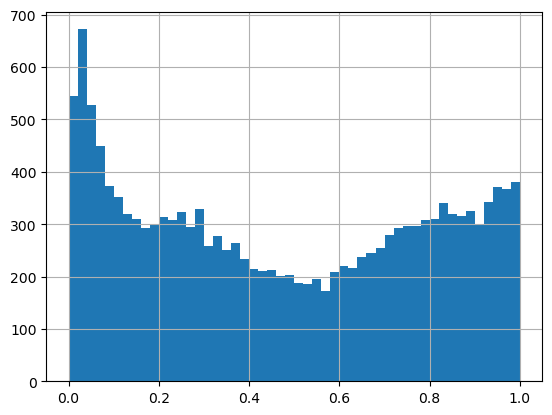

In [25]:
df_submission.probability.hist(bins=50)

In [26]:
df_submission.probability.min()

0.0008412048846366815

In [27]:
df_submission.probability.max()

0.9999998807907104